In [1]:

!wget https://bit.ly/3kiuN93
!mv 3kiuN93 ShoeV2.zip
!unzip ShoeV2.zip
!unzip ShoeV2_F/ShoeV2_photo.zip

#!wget https://www.dropbox.com/s/g6b6gtvmdu0h77x/ShoeV2_photo.zip

!pip install torch_snippets
from torch_snippets import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

--2024-03-12 17:36:23--  https://bit.ly/3kiuN93
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.qmul.ac.uk/~qian/Qian's Materials/ShoeV2.zip [following]
--2024-03-12 17:36:23--  https://www.eecs.qmul.ac.uk/~qian/Qian's%20Materials/ShoeV2.zip
Resolving www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)... 

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

138.37.95.147
Connecting to www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)|138.37.95.147|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-03-12 17:36:26 ERROR 404: Not Found.

mv: cannot stat '3kiuN93': No such file or directory
unzip:  cannot find or open ShoeV2.zip, ShoeV2.zip.zip or ShoeV2.zip.ZIP.
unzip:  cannot find or open ShoeV2_F/ShoeV2_photo.zip, ShoeV2_F/ShoeV2_photo.zip.zip or ShoeV2_F/ShoeV2_photo.zip.ZIP.


In [2]:
!unzip /content/ShoeV2_photo.zip
!unzip /content/ShoeV2_F/ShoeV2_photo.zip


Archive:  /content/ShoeV2_photo.zip
replace ShoeV2_photo/100.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: unzip:  cannot find or open /content/ShoeV2_F/ShoeV2_photo.zip, /content/ShoeV2_F/ShoeV2_photo.zip.zip or /content/ShoeV2_F/ShoeV2_photo.zip.ZIP.


In [3]:
import torch
import torch.nn as nn
import cv2
import torchvision.transforms as transforms

In [4]:
def detect_edges(img):
  img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_gray = cv2.bilateralFilter(img_gray,5,50,50)
  img_gray_edges = cv2.Canny(img_gray,45,100)
  img_gray_edges = cv2.bitwise_not(img_gray_edges)
  img_edges = cv2.cvtColor(img_gray_edges,cv2.COLOR_GRAY2RGB)

  return img_edges

In [5]:
IMAGE_SIZE = 256

preprocess = transforms.Compose([
    transforms.Lambda(lambda x: torch.Tensor(x.copy()).permute(2,0,1).to(device))
])

normalize = lambda x:(x-127.5)/127.5

In [15]:
from torch.utils.data import Dataset

class shoes_dataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self):
      return len(self.items)
    def __getitem__(self, ix):
        f = self.items[ix]
        try: im = read(f, 1)
        except:
            blank = preprocess(Blank(IMAGE_SIZE, IMAGE_SIZE, 3))
            return blank, blank
        edges = detect_edges(im)
        im, edges = resize(im, IMAGE_SIZE), resize(edges, IMAGE_SIZE)
        im, edges = normalize(im), normalize(edges)
        self._draw_color_circles_on_src_img(edges, im)
        im, edges = preprocess(im), preprocess(edges)
        return edges, im

    def _draw_color_circles_on_src_img(self, img_src, img_target):
        non_white_coords = self._get_non_white_coordinates(img_target)
        for center_y, center_x in non_white_coords:
            self._draw_color_circle_on_src_img(img_src, img_target, center_y, center_x)

    def _get_non_white_coordinates(self, img):
        non_white_mask = np.sum(img, axis=-1) < 2.75
        non_white_y, non_white_x = np.nonzero(non_white_mask)
        # randomly sample non-white coordinates
        n_non_white = len(non_white_y)
        n_color_points = min(n_non_white, 300)
        idxs = np.random.choice(n_non_white, n_color_points, replace=False)
        non_white_coords = list(zip(non_white_y[idxs], non_white_x[idxs]))
        return non_white_coords

    def _draw_color_circle_on_src_img(self, img_src, img_target, center_y, center_x):
        assert img_src.shape == img_target.shape, "Image source and target must have same shape."
        y0, y1, x0, x1 = self._get_color_point_bbox_coords(center_y, center_x)
        color = np.mean(img_target[y0:y1, x0:x1], axis=(0, 1))
        img_src[y0:y1, x0:x1] = color

    def _get_color_point_bbox_coords(self, center_y, center_x):
        radius = 2
        y0 = max(0, center_y-radius+1)
        y1 = min(IMAGE_SIZE, center_y+radius)
        x0 = max(0, center_x-radius+1)
        x1 = min(IMAGE_SIZE, center_x+radius)
        return y0, y1, x0, x1

    def choose(self): return self[randint(len(self))]

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_items,val_items = train_test_split(
    Glob('/content/ShoeV2_photo/*.png'),test_size =0.2 , random_state = 2
)

trn_ds, val_ds = shoes_dataset(train_items),shoes_dataset(val_items)

trn_dl = DataLoader(trn_ds,batch_size = 32 ,shuffle=True)
val_dl = DataLoader(val_ds,batch_size = 32 ,shuffle=True)

In [17]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [32]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

In [33]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        def discriminator_block(in_ch, out_ch, normalization=True):
            layers = [nn.Conv2d(in_ch, out_ch, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_ch * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [34]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


from torchsummary import summary as s
s(generator,input_size=(3,256,256))
s(discriminator,input_size=[(3,256,256),(3,256,256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
          UNetDown-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
          UNetDown-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
         UNetDown-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [ ]:
discriminator

In [35]:
def discriminator_train_step(real_src, real_trg, fake_trg):
    #discriminator.train()
    d_optimizer.zero_grad()

    prediction_real = discriminator(real_trg, real_src)
    error_real = criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 16, 16).cuda())
    error_real.backward()

    prediction_fake = discriminator(fake_trg.detach(), real_src)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 16, 16).cuda())
    error_fake.backward()

    d_optimizer.step()

    return error_real + error_fake


def generator_train_step(real_src, fake_trg):
    #discriminator.train()
    g_optimizer.zero_grad()
    prediction = discriminator(fake_trg, real_src)

    loss_GAN = criterion_GAN(prediction, torch.ones(len(real_src), 1, 16, 16).cuda())
    loss_pixel = criterion_pixelwise(fake_trg, real_trg)
    loss_G = loss_GAN + lambda_pixel * loss_pixel

    loss_G.backward()
    g_optimizer.step()
    return loss_G

denorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))

def sample_prediction():
    data = next(iter(val_dl))
    real_src, real_trg = data
    fake_trg = generator(real_src)
    img_sample = torch.cat([denorm(real_src[0]), denorm(fake_trg[0]), denorm(real_trg[0])], -1)
    img_sample = img_sample.detach().cpu().permute(1,2,0).numpy()
    show(img_sample, title='Source::Generated::GroundTruth', sz=12)

In [38]:
device

'cuda'

EPOCH: 1.000  errG: 19.301  errD: 1.047  (181.77s - 17994.94s remaining)


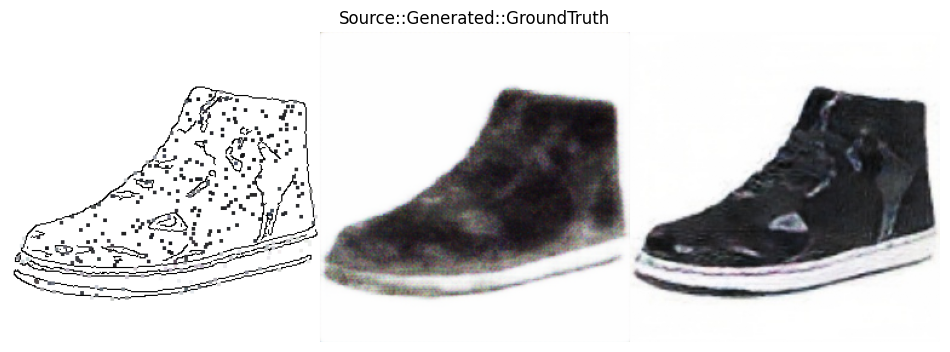

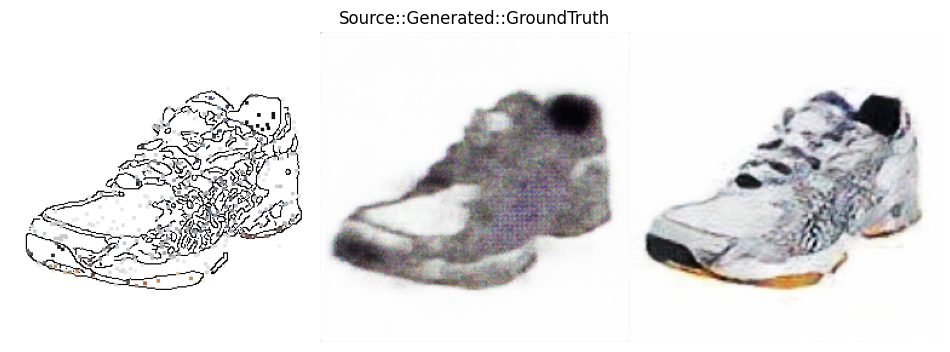

EPOCH: 2.000  errG: 10.202  errD: 0.538  (362.57s - 17766.03s remaining)


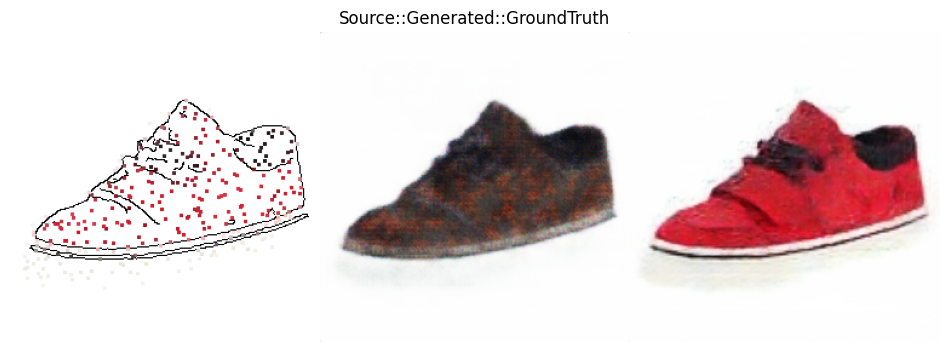

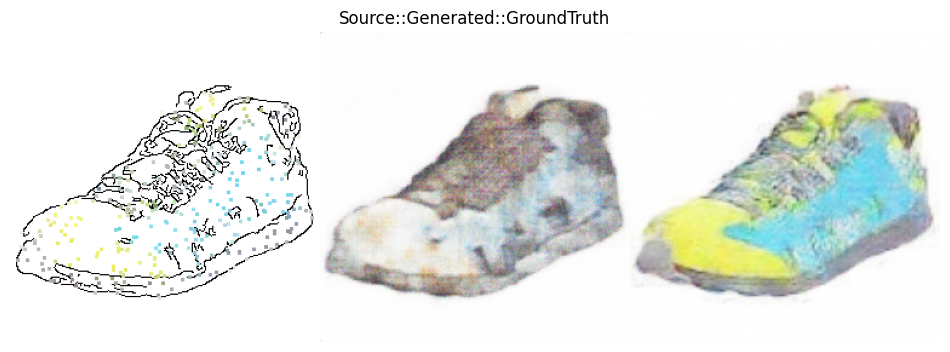

EPOCH: 3.000  errG: 8.305  errD: 0.540  (544.45s - 17603.75s remaining)


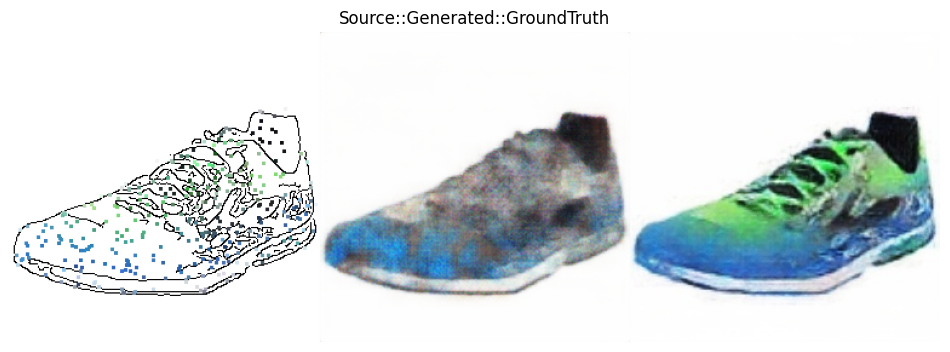

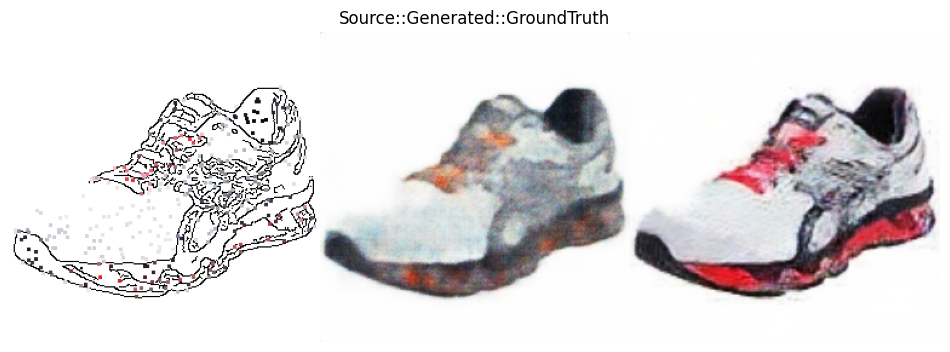

EPOCH: 4.000  errG: 7.226  errD: 0.532  (727.10s - 17450.39s remaining)


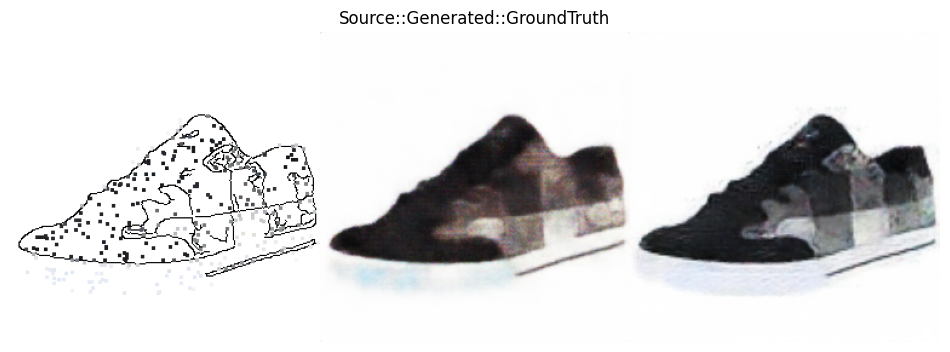

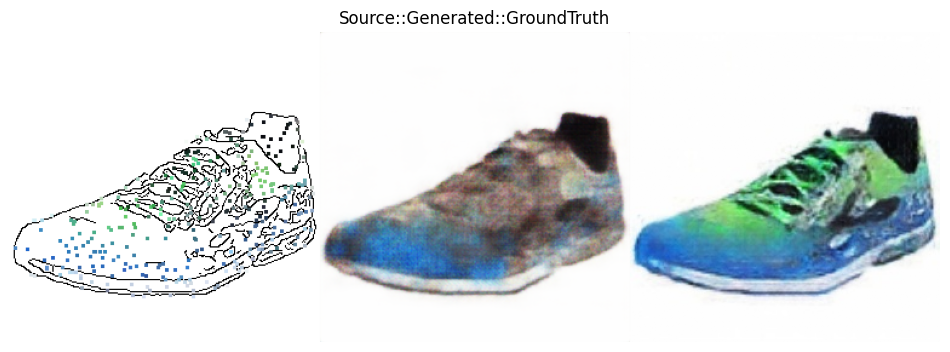

EPOCH: 5.000  errG: 6.587  errD: 0.530  (909.86s - 17287.30s remaining)


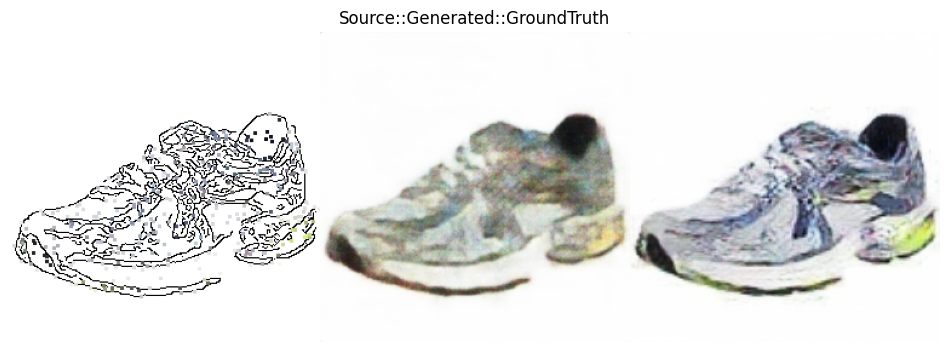

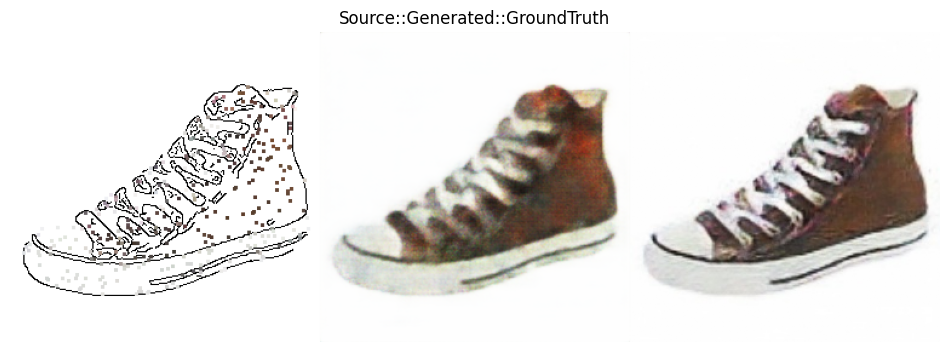

EPOCH: 6.000  errG: 6.167  errD: 0.513  (1093.53s - 17131.99s remaining)


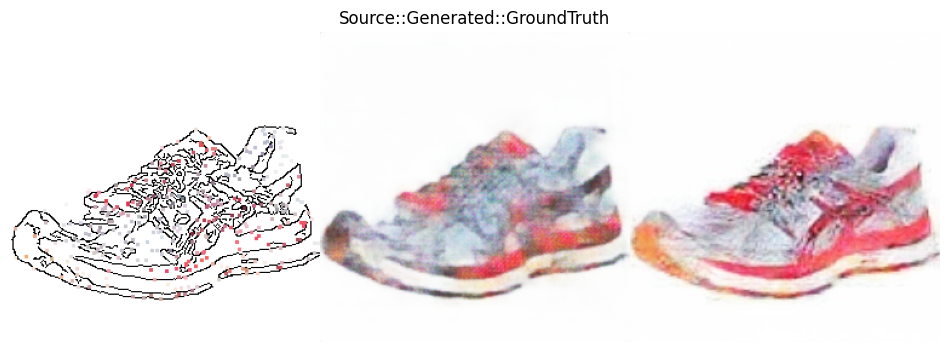

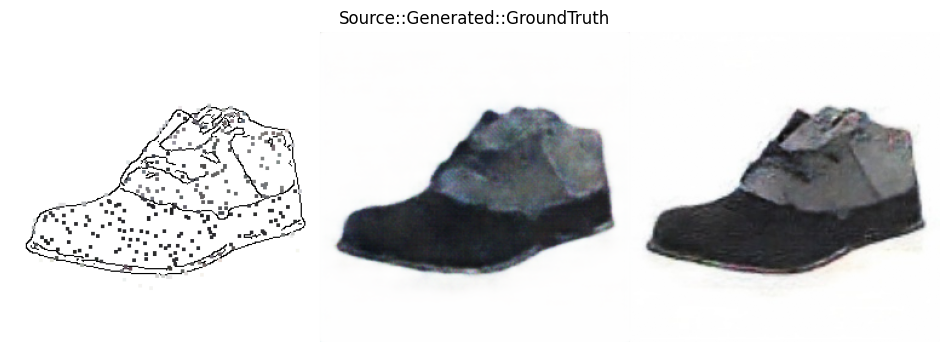

EPOCH: 7.000  errG: 5.827  errD: 0.503  (1276.73s - 16962.27s remaining)


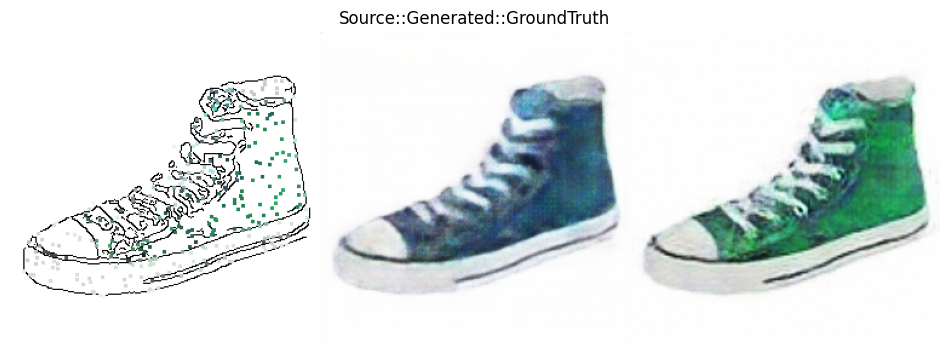

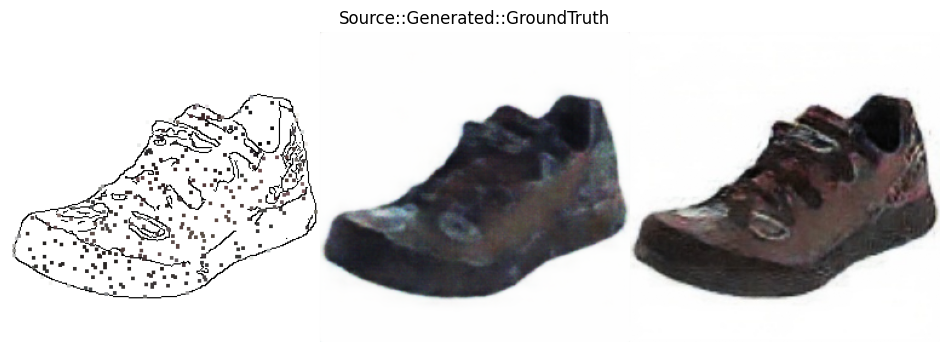

EPOCH: 8.000  errG: 5.482  errD: 0.495  (1459.82s - 16787.89s remaining)


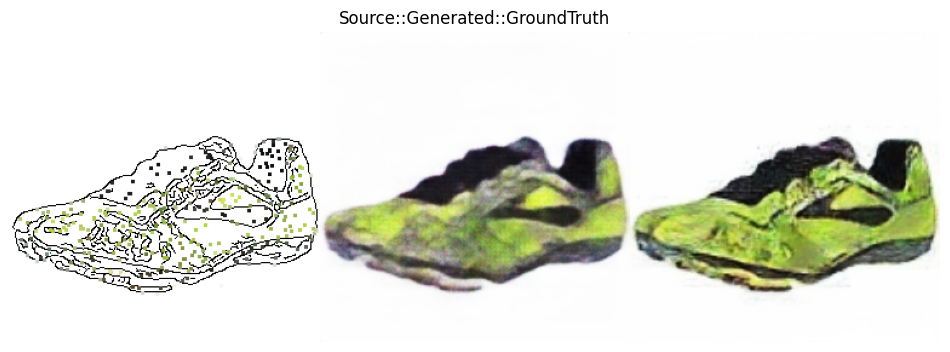

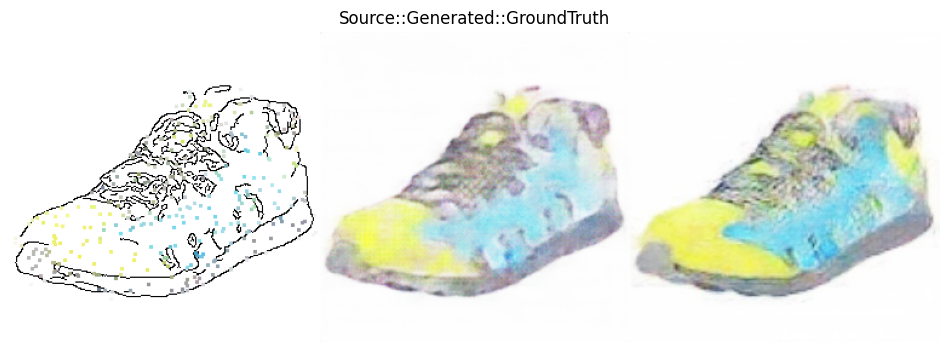

EPOCH: 9.000  errG: 5.230  errD: 0.504  (1643.24s - 16614.95s remaining)


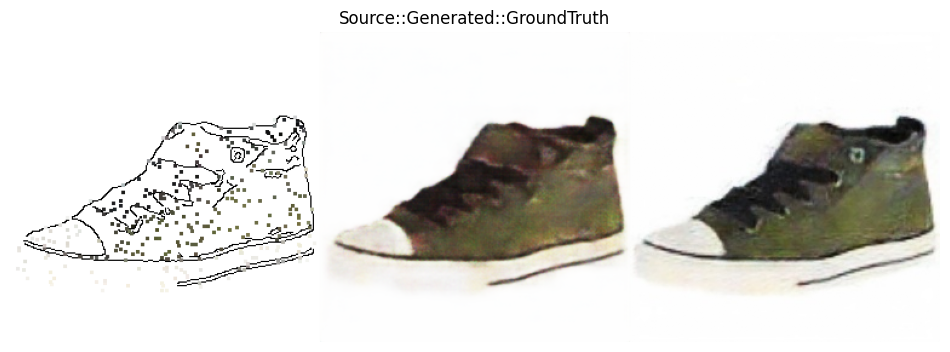

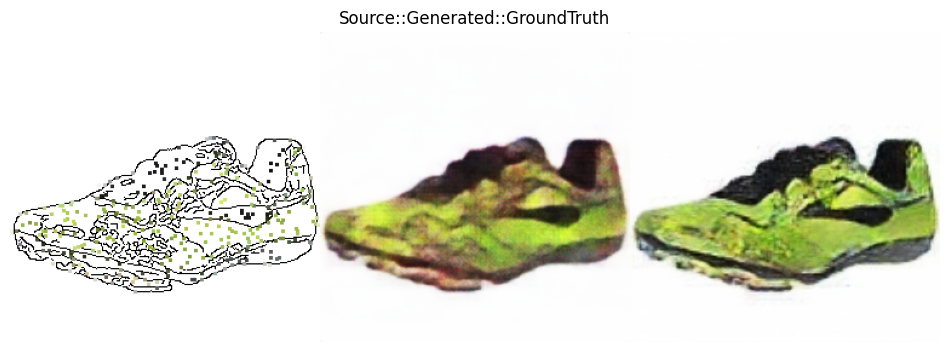

EPOCH: 9.491  errD: 0.428  errG: 5.373  (1734.18s - 16537.79s remaining)

KeyboardInterrupt: 

In [39]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

lambda_pixel = 100
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

epochs = 100
log = Report(epochs)

for epoch in range(epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_src, real_trg = batch
        fake_trg = generator(real_src)

        errD = discriminator_train_step(real_src, real_trg, fake_trg)
        errG = generator_train_step(real_src, fake_trg)
        log.record(pos=epoch+(1+bx)/N, errD=errD.item(), errG=errG.item(), end='\r')

    log.report_avgs(epoch+1)
    [sample_prediction() for _ in range(2)]